In [23]:
import numpy as np 
import matplotlib.pylab as plt
import numpy as np
from scipy.integrate import cumtrapz
from scipy.optimize import curve_fit
from importlib import reload
import sys
sys.path.append("../src")
import brownian

from matplotlib import rc
fontsize = 10
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.usetex": True, # latex-based math
    "text.latex.preamble":
        r'\usepackage{upgreek}',
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
}

plt.rcParams.update(fontstyle)

letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"] 
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()] 
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):     
    letters = letters_map[mode]     
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,             
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)

from time_series import Collection, TimeSeries, find_ders, find_files
from brownian import (abc_guess, get_krhoA,
     kB, gaussian_func, psd_func, msd_func, pac_func, vac_func, logbin_func, bin_func)
from simulation import Simulation
from brownian import PSD, ACF, AVAR, MSD


# Free particle

In [2]:
sim = Simulation()
sim.set_environment(T=300, eta=18e-6)
sim.set_particle(rho=1700, R=3e-6/2)
dt = 1/5e6
time_steps = int(500e5)
K = [0]

sim.set_under_damped()
sim.set_harmonic_trap(K=K)
sim.set_external_force(None)
sim.initialize_state(position=np.array([0]))
sim.initialize_time(dt=dt, time_steps=time_steps)
ts, qs = sim.run()
tmax = ts[-1]
xs = qs[:, 0]
vs = qs[:, 1]

SX_ub = TimeSeries(xs, name="v", r=1/dt)
SV_ub = TimeSeries(vs, r=1/dt)
params = sim.params

In [3]:
taumax = 100e-3
SX_ub.PSD(taumax=taumax, window="han")
SV_ub.PSD(taumax=taumax, window="han")
SX_ub.MSD(taumax=taumax, n_jobs=-1)
SX_ub.ACF(taumax=taumax, n_jobs=-1)
SV_ub.ACF(taumax=taumax, n_jobs=-1)

(array([0.00000e+00, 2.00000e-07, 4.00000e-07, ..., 9.99994e-02,
        9.99996e-02, 9.99998e-02]),
 array([ 1.73416407e-07,  1.72684844e-07,  1.71956541e-07, ...,
        -2.40778853e-08, -2.35569434e-08, -2.45426208e-08]),
 100)

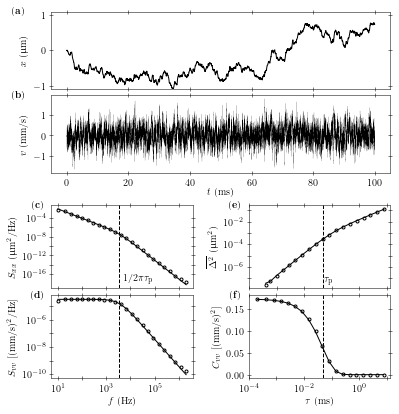

In [18]:
params = params | {"k": 1e-16}
fig = plt.figure(figsize=(5.5, 5.6))
gs1 = fig.add_gridspec(2, 2, figure=fig, top=0.98, bottom=0.58, hspace=0.08, right=0.98)
gs2 = fig.add_gridspec(2, 2, figure=fig, bottom=0.07,  top=0.5, hspace=0.08, wspace=0.4, right=0.98)
tax1 = fig.add_subplot(gs1[0, :])
pax1 = fig.add_subplot(gs2[0, 0])
sqax1 = fig.add_subplot(gs2[0, 1])
axs1 = [tax1, pax1, sqax1]

tax2 = fig.add_subplot(gs1[1, :])
pax2 = fig.add_subplot(gs2[1, 0])
sqax2 = fig.add_subplot(gs2[1, 1])
axs2 = [tax2, pax2, sqax2]

Npts = 5
color = "k"
ms = 3
lw = 1
xpsdunit = (1e6)**2
msdunit = (1e6)**2
vpsdunit = (1e3)**2
vacfunit = (1e3)**2



SX_ub.plot(ax=axs1[0], unit="um", tunit="ms", tmax=100e-3, lw=1, color=color)
SV_ub.plot(ax=axs2[0], unit="mm_s",tunit="ms", tmax=100e-3, lw=0.1, color=color)
axs1[0].set_yticks([-1,0,1])
axs1[0].set_ylim(-1.1, 1.1)

xfreq_plot = logbin_func(SX_ub.freq, Npts=Npts)
xpsd_plot = logbin_func(SX_ub.psd, Npts=Npts)
axs1[1].loglog(xfreq_plot, xpsdunit*xpsd_plot, marker="o", ms=ms, mec=color, mfc="none", ls="none", label="x (sim)")
axs1[1].loglog(xfreq_plot, xpsdunit*psd_func(xfreq_plot, **params), c=color, lw=lw, label="x (theory)")
axs1[1].axvline(1/(2*np.pi*sim.taup), c="k", ls="--", lw=1)
axs1[1].text(1/(2*np.pi*sim.taup)*1.5,  xpsdunit*xpsd_plot[-1]*2, r"$1/2 \pi \tau_{\rm p}$")

vfreq_plot = logbin_func(SV_ub.freq, Npts=Npts)
vpsd_plot = logbin_func(SV_ub.psd, Npts=Npts)
axs2[1].loglog(vfreq_plot, vpsdunit*vpsd_plot, marker="o", ms=ms, mec=color, mfc="none", ls="none", label="x (sim)")
axs2[1].loglog(vfreq_plot, vpsdunit*(2 *np.pi * vfreq_plot)**2 * psd_func(vfreq_plot, **params), c=color, lw=lw, label="x (theory)")
axs2[1].axvline(1/(2*np.pi*sim.taup), c="k", ls="--", lw=1)

xmask = SX_ub.tmsd < taumax*0.1
xtmsd_plot = logbin_func(SX_ub.tmsd[xmask], Npts=Npts)
xmsd_plot = logbin_func(SX_ub.msd[xmask], Npts=Npts)
axs1[2].loglog(1e3*xtmsd_plot, msdunit*xmsd_plot, marker="o", ms=ms, ls="none", mec=color, mfc="none", label="x (sim)")
axs1[2].loglog(1e3*xtmsd_plot, msdunit*msd_func(xtmsd_plot, **params), c=color, lw=lw, label="x (theory)")
axs1[2].axvline(1e3*sim.taup, c="k", ls="--", lw=1)
axs1[2].text(1e3*sim.taup*1.1, msdunit*xmsd_plot[0]*2, r"$\tau_{\rm p}$")

xmask = SV_ub.tacf < taumax*0.1
vtacf_plot = logbin_func(SV_ub.tacf[xmask], Npts=Npts)
vacf_plot = logbin_func(SV_ub.acf[xmask], Npts=Npts)
axs2[2].semilogx(1e3*vtacf_plot, vacfunit*vacf_plot, marker="o", ms=ms, ls="none", mec=color, mfc="none", label="v_x (sim)")
axs2[2].semilogx(1e3*vtacf_plot, vacfunit*vac_func(vtacf_plot, **params), c=color, lw=lw, label="v_x (theory)")
axs2[2].axvline(1e3*sim.taup, c="k", ls="--", lw=1)

axs1[0].set_xlabel("")
axs1[0].set_xticklabels("")
axs2[0].set_xlabel("$t$ (ms)", labelpad=-0.2)
axs1[0].set_ylabel(r"$x~{\rm (\upmu m)}$")
axs2[0].set_ylabel(r"$v$ (mm/s)")

axs1[1].set_xlabel("")
axs1[1].set_xticklabels("")
axs2[1].set_xlabel(r"$f$ (Hz)")
axs1[1].set_ylabel(r"$S_{xx}~{\rm (\upmu m^2 /Hz)}$")
axs2[1].set_ylabel(r"$S_{vv}~{\rm [(mm/s)^2/Hz]}$")
psd_xticks = [1e1,1e2,1e3,1e4,1e5,1e6]
axs1[1].set_xticks(psd_xticks)
axs2[1].set_xticks(psd_xticks)
axs2[1].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(psd_xticks)])
xpsd_yticks = [1e-16, 1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4]
axs1[1].set_yticks(xpsd_yticks)
axs1[1].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(xpsd_yticks)])
vpsd_yticks = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
axs2[1].set_yticks(vpsd_yticks)
axs2[1].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(vpsd_yticks)])


axs1[2].set_xlabel("")
axs1[2].set_xticklabels("")
axs2[2].set_xlabel(r"$\tau$ (ms)")
axs1[2].set_ylabel(r"$\overline{\Delta^2}~{\rm (\upmu m^2)}$")
axs2[2].set_ylabel(r"$C_{vv}~{\rm [(mm/s)^2]}$")
sq_xticks = [1e-4, 1e-3,1e-2,1e-1,1e0, 1e1]
axs1[2].set_xticks(sq_xticks)
axs2[2].set_xticks(sq_xticks)
axs2[2].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(sq_xticks)])
axs2[2].set_yticks([0, 0.05, 0.1, 0.15])
msd_yticks = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
axs1[2].set_yticks(msd_yticks)
axs1[2].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==1 else "" for di, d in enumerate(msd_yticks)])

lettering(axs1[0], -0.1, 1., 0)
lettering(axs2[0], -0.1, 1., 1)
lettering(axs1[1], -0.1, 1., 2)
lettering(axs2[1], -0.1, 1., 3)
lettering(axs1[2], -0.1, 1., 4)
lettering(axs2[2], -0.1, 1., 5)


plt.savefig("figures/dissertation/free_brownian_air.pdf", dpi=600)

# Harmonic confinement

In [5]:
sim = Simulation()
sim.set_environment(T=300, eta=18e-6)
sim.set_particle(rho=1700, R=3e-6/2)
dt = 1/5e6
time_steps = int(500e5)
K = [1e-6, 50e-6]

sim.set_under_damped()
sim.set_harmonic_trap(K=K)
sim.set_external_force(None)
sim.initialize_state(position=np.array([0]))
sim.initialize_time(dt=dt, time_steps=time_steps)
ts, qs = sim.run() 
tmax = ts[-1]

SX = TimeSeries(xs, name="v", r=1/dt)
SV = TimeSeries(vs, r=1/dt)
params = sim.params

In [6]:
names = ["x", "y", "vx", "vy"]
S_list = []
params_list = []
for xs, name in zip(qs.T, names):
    coordi = "xyz".index(name[-1])
    k = sim.K[coordi]
    params = sim.params
    params = params | {"k": k}
    params_list.append(params)
    
    S = TimeSeries(xs, name=name, r=1/dt)
    S.PSD(taumax=taumax, window="han")
    S.ACF(taumax=taumax, n_jobs=-1)
    S.MSD(taumax=taumax, n_jobs=-1)
    S.HIST(Nbins=20)
    S_list.append(S)

In [10]:
SXs, SVs = [S_list[0], S_list[1]], [S_list[2], S_list[3]]

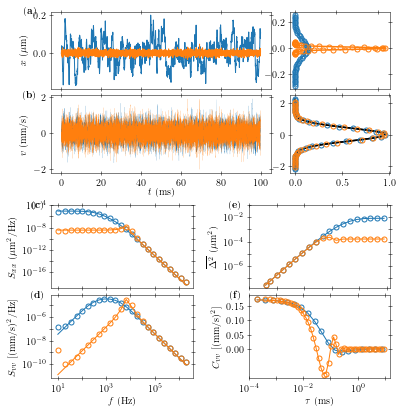

In [13]:
K = [1e-6, 50e-6]

fig = plt.figure(figsize=(5.5, 5.6))
gs1 = fig.add_gridspec(2, 3, figure=fig, top=0.98, bottom=0.58, hspace=0.08, right=0.98)
gs2 = fig.add_gridspec(2, 2, figure=fig, bottom=0.07,  top=0.5, hspace=0.08, wspace=0.4, right=0.98)
tax1 = fig.add_subplot(gs1[0, :2])
probax1 = fig.add_subplot(gs1[0, 2])
pax1 = fig.add_subplot(gs2[0, 0])
sqax1 = fig.add_subplot(gs2[0, 1])
axs1 = [tax1, probax1, pax1, sqax1]

tax2 = fig.add_subplot(gs1[1, :2])
probax2 = fig.add_subplot(gs1[1, 2])
pax2 = fig.add_subplot(gs2[1, 0])
sqax2 = fig.add_subplot(gs2[1, 1])
axs2 = [tax2, probax2, pax2, sqax2]

Npts = 5
ms = 5
lw = 1
xpsdunit = (1e6)**2
msdunit = (1e6)**2
vpsdunit = (1e3)**2
vacfunit = (1e3)**2
SXs = S_list[:2]
SVs = S_list[2:]
colors = ["C0", "C1"]
for SX, SV, params, color in zip(SXs, SVs, params_list[:2], colors):
    SX.plot(ax=axs1[0], unit="um", tunit="ms", tmax=100e-3, lw=1, color=color)
    SV.plot(ax=axs2[0], unit="mm_s",tunit="ms", tmax=100e-3, lw=0.1, color=color)
    
    axs1[1].plot(gaussian_func(SX.bins, var=kB*params["T"] / params["k"])/1e6, 1e6*SX.bins, c=color, label="x (theory)", zorder=0)
    axs1[1].plot(SX.hist/1e6, 1e6*SX.bins, marker="o", ls="none", mec=color, mfc="none", ms=ms, label="x (sim)")
    axs2[1].plot(gaussian_func(SV.bins, var=kB*params["T"] / sim.mass)/1e3, 1e3*SV.bins, c="k", label="x (theory)", zorder=0)
    axs2[1].plot(SV.hist/1e3, 1e3*SV.bins, marker="o", ls="none", mec=color, mfc="none", ms=ms, label="x (sim)")

    xfreq_plot = logbin_func(SX.freq, Npts=Npts)
    xpsd_plot = logbin_func(SX.psd, Npts=Npts)
    axs1[2].loglog(xfreq_plot, xpsdunit*xpsd_plot, marker="o", ms=ms, mec=color, mfc="none", ls="none", label="x (sim)")
    axs1[2].loglog(xfreq_plot, xpsdunit*psd_func(xfreq_plot, **params), c=color, lw=lw, label="x (theory)")
    #axs1[2].axvline(1/(2*np.pi*sim.taup), c="k", ls="--", lw=1)
    #axs1[2].text(1/(2*np.pi*sim.taup)*1.5,  xpsdunit*xpsd_plot[-1]*2, r"$1/2 \pi \tau_{\rm p}$")

    vfreq_plot = logbin_func(SV.freq, Npts=Npts)
    vpsd_plot = logbin_func(SV.psd, Npts=Npts)
    axs2[2].loglog(vfreq_plot, vpsdunit*vpsd_plot, marker="o", ms=ms, mec=color, mfc="none", ls="none", label="x (sim)")
    axs2[2].loglog(vfreq_plot, vpsdunit*(2 *np.pi * vfreq_plot)**2 * psd_func(vfreq_plot, **params), c=color, lw=lw, label="x (theory)")
    #axs2[2].axvline(1/(2*np.pi*sim.taup), c="k", ls="--", lw=1)

    xmask = SX.tmsd < taumax*0.1
    xtmsd_plot = logbin_func(SX.tmsd[xmask], Npts=Npts)
    xmsd_plot = logbin_func(SX.msd[xmask], Npts=Npts)
    axs1[3].loglog(1e3*xtmsd_plot, msdunit*xmsd_plot, marker="o", ms=ms, ls="none", mec=color, mfc="none", label="x (sim)")
    axs1[3].loglog(1e3*xtmsd_plot, msdunit*msd_func(xtmsd_plot, **params), c=color, lw=lw, label="x (theory)")
    #axs1[3].axvline(1e3*sim.taup, c="k", ls="--", lw=1)
    #axs1[3].text(1e3*sim.taup*1.1, msdunit*xmsd_plot[0]*2, r"$\tau_{\rm p}$")

    xmask = SV.tacf < taumax*0.1
    if params["k"] == K[1]:
        vacf_Npts = 13
    else:
        vacf_Npts = Npts      
    vtacf_plot = logbin_func(SV.tacf[xmask], Npts=vacf_Npts)
    vacf_plot = logbin_func(SV.acf[xmask], Npts=vacf_Npts)
    axs2[3].semilogx(1e3*vtacf_plot, vacfunit*vacf_plot, marker="o", ms=ms, ls="none", mec=color, mfc="none", label="v_x (sim)")
    axs2[3].semilogx(1e3*vtacf_plot, vacfunit*vac_func(vtacf_plot, **params), c=color, lw=lw, label="v_x (theory)")
    #axs2[3].axvline(1e3*sim.taup, c="k", ls="--", lw=1)


axs1[0].set_xlabel("")
axs1[0].set_xticklabels("")
axs2[0].set_xlabel("$t$ (ms)", labelpad=-0.2)
axs1[0].set_ylabel(r"$x~{\rm (\upmu m)}$")
axs2[0].set_ylabel(r"$v$ (mm/s)")

axs1[2].set_xlabel("")
axs1[2].set_xticklabels("")
axs2[2].set_xlabel(r"$f$ (Hz)")
axs1[2].set_ylabel(r"$S_{xx}~{\rm (\upmu m^2 /Hz)}$")
axs2[2].set_ylabel(r"$S_{vv}~{\rm [(mm/s)^2/Hz]}$")
psd_xticks = [1e1,1e2,1e3,1e4,1e5,1e6]
axs1[2].set_xticks(psd_xticks)
axs2[2].set_xticks(psd_xticks)
axs2[2].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(psd_xticks)])
xpsd_yticks = [1e-16, 1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4]
axs1[2].set_yticks(xpsd_yticks)
axs1[2].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(xpsd_yticks)])
vpsd_yticks = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
axs2[2].set_yticks(vpsd_yticks)
axs2[2].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(vpsd_yticks)])


axs1[3].set_xlabel("")
axs1[3].set_xticklabels("")
axs2[3].set_xlabel(r"$\tau$ (ms)")
axs1[3].set_ylabel(r"$\overline{\Delta^2}~{\rm (\upmu m^2)}$")
axs2[3].set_ylabel(r"$C_{vv}~{\rm [(mm/s)^2]}$")
sq_xticks = [1e-4, 1e-3,1e-2,1e-1,1e0, 1e1]
axs1[3].set_xticks(sq_xticks)
axs2[3].set_xticks(sq_xticks)
axs2[3].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(sq_xticks)])
axs2[3].set_yticks([0, 0.05, 0.1, 0.15])
msd_yticks = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
axs1[3].set_yticks(msd_yticks)
axs1[3].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==1 else "" for di, d in enumerate(msd_yticks)])

lettering(axs1[0], -0.1, 1., 0)
lettering(axs2[0], -0.1, 1., 1)
lettering(axs1[2], -0.1, 1., 2)
lettering(axs2[2], -0.1, 1., 3)
lettering(axs1[3], -0.1, 1., 4)
lettering(axs2[3], -0.1, 1., 5)

k= 1e-06
k= 5e-05


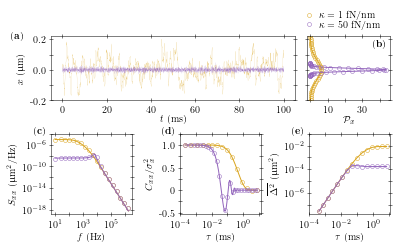

In [20]:
K = [1e-6, 50e-6]

fig = plt.figure(figsize=(5.5, 3.3))
gs1 = fig.add_gridspec(1, 100, figure=fig, top=0.89, bottom=0.62, hspace=0.08, wspace=1, right=0.98)
gs2 = fig.add_gridspec(1, 3, figure=fig, bottom=0.14,  top=0.48, hspace=0.08, wspace=0.6, right=0.98)
tax1 = fig.add_subplot(gs1[0, :72])
probax1 = fig.add_subplot(gs1[0, 75:])
pax1 = fig.add_subplot(gs2[0, 0])
acfax1 = fig.add_subplot(gs2[0, 1])
msdax1 = fig.add_subplot(gs2[0, 2])
axs1 = [tax1, probax1, pax1, acfax1, msdax1]
axs1 = [tax1, probax1, pax1, acfax1, msdax1]



Npts = 4
ms = 4
mew=0.5
lw = 1
xpsdunit = (1e6)**2
msdunit = (1e6)**2
vpsdunit = (1e3)**2
vacfunit = (1e3)**2
xacfunit = (1e6)**2
SXs = S_list[:2]
SVs = S_list[2:]
colors = ["goldenrod", "C4"]
for SX, SV, params, color in zip(SXs, SVs, params_list[:2], colors):
    print("k=", params["k"])
    #print(kB*params["T"]/params["k"], SX.acf[0], np.var(SX.x), trapz(SX.psd, x=SX.freq))
    SX.plot(ax=axs1[0], unit="um", tunit="ms", tmax=100e-3, lw=0.1, color=color)
    
    axs1[1].plot(gaussian_func(SX.bins, var=kB*params["T"] / params["k"])/1e6, 1e6*SX.bins, lw=lw, c=color, zorder=0)
    axs1[1].plot(SX.hist/1e6, 1e6*SX.bins, marker="o", ls="none", mec=color, mfc="none", ms=ms, mew=mew, label=r"$\kappa=%s~{\rm fN/nm}$"%int(params["k"]*1e6))
    
    xfreq_plot = logbin_func(SX.freq, Npts=Npts)
    xpsd_plot = logbin_func(SX.psd, Npts=Npts)
    axs1[2].loglog(xfreq_plot, xpsdunit*xpsd_plot, marker="o", ms=ms, mew=mew, mec=color, mfc="none", ls="none", label="x (sim)")
    axs1[2].loglog(np.geomspace(xfreq_plot[0], xfreq_plot[-1], 200), xpsdunit*psd_func(np.geomspace(xfreq_plot[0], xfreq_plot[-1], 200), **params), c=color, lw=lw, label="x (theory)")
   

    if params["k"] == K[1]:
        acf_Npts = 7
    else:
        acf_Npts = Npts      
    xmask = SX.tacf < taumax*0.1
    xtacf_plot = logbin_func(SX.tacf[xmask], Npts=acf_Npts)
    xacf_plot = logbin_func(SX.acf[xmask], Npts=acf_Npts)
    axs1[3].semilogx(1e3*xtacf_plot, xacf_plot/np.var(SX.x), marker="o", ms=ms, mew=mew, ls="none", mec=color, mfc="none", label="x (sim)")
    axs1[3].semilogx(1e3*np.geomspace(xtacf_plot[0], xtacf_plot[-1], 200), pac_func(np.geomspace(xtacf_plot[0], xtacf_plot[-1], 200), **params)/(kB*params["T"] / params["k"]), c=color, lw=lw, label="x (theory)")


    xmask = SX.tmsd < taumax*0.1
    xtmsd_plot = logbin_func(SX.tmsd[xmask], Npts=Npts)
    xmsd_plot = logbin_func(SX.msd[xmask], Npts=Npts)
    axs1[4].loglog(1e3*xtmsd_plot, msdunit*xmsd_plot, marker="o", ms=ms, mew=mew, ls="none", mec=color, mfc="none", label="x (sim)")
    axs1[4].loglog(1e3*xtmsd_plot, msdunit*msd_func(xtmsd_plot, **params), c=color, lw=lw, label="x (theory)")
    


axs1[0].set_xlabel("$t$ (ms)", labelpad=-0.2)
axs1[0].set_ylabel(r"$x~{\rm (\upmu m)}$")
axs1[0].set_yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
axs1[0].set_yticklabels([-0.2, "", 0.0, "", 0.2])


axs1[1].set_xlabel(r"$\mathcal{P}_x$", labelpad=-0.2)
axs1[1].set_yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
axs1[1].set_yticklabels([])
axs1[1].set_yticklabels([])
axs1[1].set_xticks([0,10,20,30,40])
axs1[1].set_xticklabels(["", 10, "", 30, ""])
axs1[1].set_ylim(*axs1[0].get_ylim())


axs1[2].set_xlabel(r"$f$ (Hz)")
axs1[2].set_ylabel(r"$S_{xx}~{\rm (\upmu m^2 /Hz)}$")
psd_xticks = [1e1,1e2,1e3,1e4,1e5,1e6]
axs1[2].set_xticks(psd_xticks)
axs1[2].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(psd_xticks)])
xpsd_yticks = [1e-18, 1e-16, 1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4]
axs1[2].set_yticks(xpsd_yticks)
axs1[2].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(xpsd_yticks)])



axs1[3].set_ylabel(r"$C_{xx}/\sigma^2_x$")
axs1[3].set_xlabel(r"$\tau$ (ms)")
sq_xticks = [1e-4, 1e-3,1e-2,1e-1,1e0, 1e1]
axs1[3].set_xticks(sq_xticks)
axs1[3].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(sq_xticks)])
axs1[3].set_yticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25])
axs1[3].set_yticklabels([-0.5, "", 0, "", 0.5, "", 1.0, ""])


axs1[4].set_xlabel(r"$\tau$ (ms)")
axs1[4].set_ylabel(r"$\overline{\Delta^2}~{\rm (\upmu m^2)}$")
axs1[4].set_xticks(sq_xticks)
axs1[4].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(sq_xticks)])
msd_yticks = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
axs1[4].set_yticks(msd_yticks)
axs1[4].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==1 else "" for di, d in enumerate(msd_yticks)])

lettering(axs1[0], -0.143, 1., 0)
lettering(axs1[1], 0.87, 0.87, 1)
lettering(axs1[2], -0.15, 1.03, 2)
lettering(axs1[3], -0.15, 1.03, 3)
lettering(axs1[4], -0.15, 1.03, 4)

axs1[1].legend(frameon=False, labelspacing=0, handletextpad=0, columnspacing=0.5, ncol=1,
               loc="lower left", bbox_to_anchor=(-0.2, 0.95))

plt.savefig("figures/dissertation/bound_brownian_air_x-stats.pdf", dpi=600)

k= 1e-06
k= 5e-05


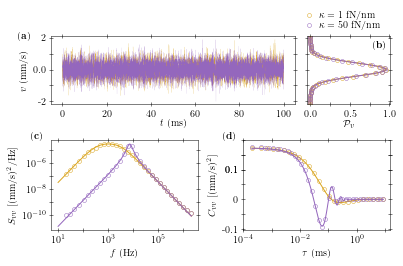

In [24]:
# K = [1e-6, 50e-6]

fig = plt.figure(figsize=(5.5, 3.5))
gs1 = fig.add_gridspec(1, 100, figure=fig, top=0.89, bottom=0.62, hspace=0.08, wspace=1, right=0.98)
gs2 = fig.add_gridspec(1, 4, figure=fig, bottom=0.12,  top=0.48, hspace=0.08, wspace=0.9, right=0.98)
tax1 = fig.add_subplot(gs1[0, :72])
probax1 = fig.add_subplot(gs1[0, 75:])
pax1 = fig.add_subplot(gs2[0, :2])
acfax1 = fig.add_subplot(gs2[0, 2:])

axs1 = [tax1, probax1, pax1, acfax1]
axs1 = [tax1, probax1, pax1, acfax1]



Npts = 7
ms = 4
mew=0.5
lw = 1
xpsdunit = (1e6)**2
msdunit = (1e6)**2
vpsdunit = (1e3)**2
vacfunit = (1e3)**2
xacfunit = (1e6)**2
SXs = S_list[:2]
SVs = S_list[2:]
colors = ["goldenrod", "C4"]
for SX, SV, params, color in zip(SXs, SVs, params_list[:2], colors):
    print("k=", params["k"])
    #print(kB*params["T"]/sim.mass, SV.acf[0], np.var(SV.x), trapz(SV.psd, x=SV.freq))
    SV.plot(ax=axs1[0], unit="mm_s", tunit="ms", tmax=100e-3, lw=0.1, color=color)
    axs1[1].plot(gaussian_func(SV.bins, var=kB*params["T"] / sim.mass)/1e3, 1e3*SV.bins, lw=lw, c=color, zorder=0)
    axs1[1].plot(SV.hist/1e3, 1e3*SV.bins, marker="o", ls="none", mec=color, mfc="none", ms=ms, mew=mew, label=r"$\kappa=%s~{\rm fN/nm}$"%int(params["k"]*1e6))
    
    vfreq_plot = logbin_func(SV.freq, Npts=Npts)
    vpsd_plot = logbin_func(SV.psd, Npts=Npts)
    #vfreq_plot = np.array([SV.freq[2**i] for i in range(int(np.log2(len(SV.freq))))])
    #vpsd_plot = np.array([SV.psd[2**i] for i in range(int(np.log2(len(SV.psd))))])
    axs1[2].loglog(vfreq_plot[1:], vpsdunit*vpsd_plot[1:], marker="o", ms=ms, mew=mew, mec=color, mfc="none", ls="none", label="x (sim)")
    axs1[2].loglog(np.geomspace(vfreq_plot[0], vfreq_plot[-1], 200), (2*np.pi*np.geomspace(vfreq_plot[0], vfreq_plot[-1], 200))**2*vpsdunit*psd_func(np.geomspace(vfreq_plot[0], vfreq_plot[-1], 200), **params), c=color, lw=lw, label="x (theory)")
   

    if params["k"] == K[1]:
        acf_Npts = 10
    else:
        acf_Npts = Npts      
    vmask = SV.tacf < taumax*0.1
    vtacf_plot = logbin_func(SV.tacf[vmask], Npts=acf_Npts)
    vacf_plot = logbin_func(SV.acf[vmask], Npts=acf_Npts)
    axs1[3].semilogx(1e3*vtacf_plot, vacfunit*vacf_plot, marker="o", ms=ms, mew=mew, ls="none", mec=color, mfc="none", label="x (sim)")
    axs1[3].semilogx(1e3*np.geomspace(vtacf_plot[0], vtacf_plot[-1], 200), vacfunit*vac_func(np.geomspace(vtacf_plot[0], vtacf_plot[-1], 200), **params), c=color, lw=lw, label="x (theory)")



axs1[0].set_xlabel("$t$ (ms)", labelpad=-0.2)
axs1[0].set_ylabel(r"$v~{\rm (mm/s)}$")
axs1[0].set_yticks([-2, -1, 0.0, 1, 2])
axs1[0].set_yticklabels([-2, "", 0.0, "", 2])


axs1[1].set_xlabel(r"$\mathcal{P}_v$", labelpad=0.25)
axs1[1].set_yticks([-2, -1, 0.0, 1, 2])
axs1[1].set_yticklabels([])
axs1[1].set_xticks([0, 0.25, 0.5, 0.75, 1])
axs1[1].set_xticklabels([0.0, "", 0.5, "", 1.0])
axs1[1].set_ylim(*axs1[0].get_ylim())



axs1[2].set_xlabel(r"$f$ (Hz)")
axs1[2].set_ylabel(r"$S_{vv}~{\rm [(mm/s)^2/Hz]}$")
vpsd_yticks = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
axs1[2].set_yticks(vpsd_yticks)
axs1[2].set_yticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(vpsd_yticks)])

psd_xticks = [1e1,1e2,1e3,1e4,1e5,1e6]
axs1[2].set_xticks(psd_xticks)
axs1[2].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(psd_xticks)])

axs1[3].set_ylabel(r"$C_{vv}~{\rm [(mm/s)^2]}$")
axs1[3].set_yticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.1, 0.15, 0.2])
axs1[3].set_yticklabels([-0.1, "", 0, "", 0.1, "", 0.1, "", ""])
axs1[3].set_xlabel(r"$\tau$ (ms)")
sq_xticks = [1e-4, 1e-3,1e-2,1e-1,1e0, 1e1]
axs1[3].set_xticks(sq_xticks)
axs1[3].set_xticklabels([r"$10^{%s}$"%int(np.log10(d)) if di%2==0 else "" for di, d in enumerate(sq_xticks)])


lettering(axs1[0], -0.113, 1., 0)
lettering(axs1[1], 0.87, 0.87, 1)
lettering(axs1[2], -0.1, 1.03, 2)
lettering(axs1[3], -0.1, 1.03, 3)

axs1[1].legend(frameon=False, labelspacing=0, handletextpad=0, columnspacing=0.5, ncol=1,
               loc="lower left", bbox_to_anchor=(-0.2, 0.95))

plt.savefig("figures/dissertation/bound_brownian_air_v-stats.pdf", dpi=600)

# 2D picture

In [381]:
sim = Simulation()
sim.set_environment(T=300, eta=18e-6)
sim.set_particle(rho=1700, R=3e-6/2)
dt = 1/1e5
time_steps = int(10e5)
K = [0,0]

sim.set_under_damped()
sim.set_harmonic_trap(K=K)
sim.set_external_force(None)
sim.initialize_state(position=np.array([0]))
sim.initialize_time(dt=dt, time_steps=time_steps)
ts, qs = sim.run()
tmax = ts[-1]
xs = qs[:, 0]
ys = qs[:, 1]

Sx = TimeSeries(xs, name="v", r=1/dt)
Sy = TimeSeries(ys, r=1/dt)
params = sim.params

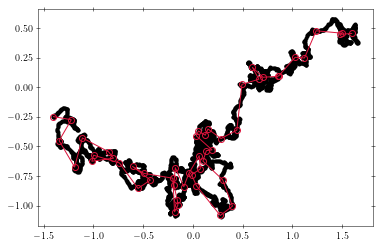

In [382]:
i0 = 4050
i1 = 9000
Di = 100
plt.plot(1e6*Sy.x[i0:i1],-1e6*Sx.x[i0:i1], marker=".", c="k", lw=1)
plt.plot(1e6*Sy.x[i0:i1:Di],-1e6*Sx.x[i0:i1:Di], marker="o", c="crimson", mec="crimson", mfc="none", lw=1)


In [736]:
# https://stackoverflow.com/questions/45076945/matplotlib-mark-inset-with-different-edges-for-axes
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2


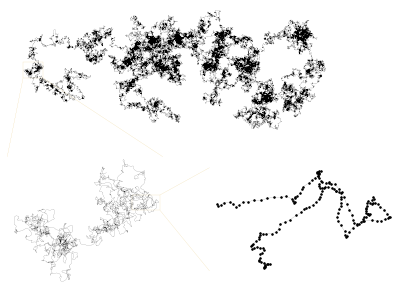

In [974]:

from matplotlib import patches
fig, ax = plt.subplots(1,1,figsize=(5.5, 4))
axins = ax.inset_axes([-0.3, -1.2, 1, 1])
axins2 = axins.inset_axes([1.3, -0.1, 1.2, 1.2])
i0 = 0
i1 = -1

#ax.plot(1e6*Sy.x,-1e6*Sx.x, marker="o", c="crimson", mec="crimson", mfc="none", lw=1, ms=5)
Sx.restore()
Sy.restore()
t, y, x = Sx.t, 1e6*Sx.x, -1e6*Sy.x

ax.plot(x, y, c="k", lw=0.1)
#ax.annotate("", xy=(x[-1], y[-1]), xytext=(x[0], y[0]), arrowprops=dict(arrowstyle="->"), color="r")
#ax.add_patch(patches.Circle((0, 0),radius=1e6*np.sqrt(2*D*Sx.t[-1]),color='goldenrod', linewidth=1, fill=False))

dd = 0.05
mnx, mxx = np.min(x), np.max(x)
mny, mxy = np.min(y), np.max(y)
bx1, bx2 = (1-np.sign(mnx)*dd)*mnx,  (1+np.sign(mxx)*dd)*mxx
by1, by2 = (1-np.sign(mny)*dd)*mny,  (1+np.sign(mxy)*dd)*mxy
ax.set_xlim(bx1, bx2)
ax.set_ylim(by1, by2)

tstart = .38
Dt = t[-10]/100
mask = np.logical_and(t > tstart, t<tstart+Dt)
t0 = t[mask][0]
x0 = x[mask][0]
y0 = y[mask][0]
t1 = t[mask][-1]
x1 = x[mask][-1]
y1 = y[mask][-1]

dd=0.02
mnx, mxx = np.min(x[mask]), np.max(x[mask])
mny, mxy = np.min(y[mask]), np.max(y[mask])
bx1, bx2 = (1-np.sign(mnx)*dd)*mnx,  (1+np.sign(mxx)*dd)*mxx
by1, by2 = (1-np.sign(mny)*dd)*mny,  (1+np.sign(mxy)*dd)*mxy
#axins.add_patch(patches.Circle((x0, y0), radius=1e6*np.sqrt(2*D*(t1-t0)),color='goldenrod', linewidth=1, fill=False))
axins.plot(x[mask], y[mask], c="k", lw=0.1)
axins.set_xlim(bx1, bx2)
axins.set_ylim(by1, by2)
axins.set_xticklabels([])
axins.set_yticklabels([])
mark_inset(ax, axins, loc1a=2, loc1b=3, loc2a=1, loc2b=4, fc="none", ec="goldenrod", lw=0.1)



Dt =15.*m/g
tstart = t[mask][np.argmax(x[mask])]  - 1.85* Dt/2
mask = np.logical_and(t > tstart-Dt/2.5, t<Dt+tstart+Dt)
t0 = t[mask][0]
x0 = x[mask][0]
y0 = y[mask][0]
t1 = t[mask][-1]
x1 = x[mask][-1]
y1 = y[mask][-1]

dd=0.005
mnx, mxx = np.min(x[mask]), np.max(x[mask])
mny, mxy = np.min(y[mask]), np.max(y[mask])
bx1, bx2 = (1-np.sign(mnx)*dd)*mnx,  (1+np.sign(mxx)*dd)*mxx
by1, by2 = (1-np.sign(mny)*dd)*mny,  (1+np.sign(mxy)*dd)*mxy
axins2.set_xlim(bx1, bx2)
axins2.set_ylim(by1, by2)
axins2.set_xticklabels([])
axins2.set_yticklabels([])
#rect, connects = axins.indicate_inset_zoom(axins2, edgecolor="goldenrod", alpha=1)
#for c in connects:
#    c.set_linewidth(1)
    
axins2.plot(x[mask], y[mask], c="k", lw=0.1, marker=".", ms="3")
Sx.bin_average(Npts=7, inplace=True)
Sy.bin_average(Npts=7, inplace=True)
t, y, x = Sx.t, 1e6*Sx.x, -1e6*Sy.x
mask = np.logical_and(t > tstart, t<tstart+Dt)
#axins2.plot(x[mask][::], y[mask][::], marker="o", c="crimson", mec="crimson", mfc="none", lw=0.5, ms=5, zorder=1)
mark_inset(axins, axins2, loc1a=2, loc1b=1, loc2a=3, loc2b=4, fc="none", ec="goldenrod", lw=0.1)

ax.autoscale_view()
axins.autoscale_view()
axins2.autoscale_view()
ax.set_aspect(1)
axins.set_aspect(1)
axins2.set_aspect(1)
ax.set_axis_off()
axins.set_axis_off()
axins2.set_axis_off()
axins.set_xticks([])
axins.set_yticks([])
axins2.set_xticks([])
axins2.set_yticks([])
#plt.tight_layout()
plt.subplots_adjust(top=1.35, bottom=0.2, left = 0.05, right=0.85)
plt.savefig("figures/dissertation/brownian_motion_zoom.pdf", dpi=600)

In [934]:
Dt*1e3

0.7083333333333333

In [125]:
g = 6*np.pi * params["R"] * params["viscosity"]
m = 4/3*np.pi * params["rho"]*params["R"]**3
D = kB * params["T"] / g


In [ ]:


ax1.add_patch(patches.Circle((0.5, 0.5),
                             radius=0.5,
                             color='k', linewidth=10, fill=False))
ax1.autoscale_view()